In [1]:
import os
import sys
import glob

ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
SRC = os.path.join(ROOT, 'src')
sys.path.append(SRC)

import mirdata
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from collections import defaultdict
import seaborn as sns

In [2]:
results_folder = os.path.join(ROOT, 'output', 'results', 'tcn_carnatic_fs')

### Read result CSV files

In [3]:
# Scan for CSV files and organize by trainfold
csv_files = glob.glob(os.path.join(results_folder, 'tcn_carnatic_fs-trainfold*-run*.csv'))

In [ ]:
# Dictionary to store dataframes by trainfold
trainfold_data = defaultdict(list)

# Read each CSV file
for csv_file in csv_files:
    filename = os.path.basename(csv_file)
    
    # Extract trainfold and run numbers from filename
    if 'trainfold1' in filename:
        trainfold = 1
    elif 'trainfold2' in filename:
        trainfold = 2
    else:
        continue  # Skip files that don't match expected pattern
    
    # Read CSV excluding last 5 rows
    df = pd.read_csv(csv_file)
    df_trimmed = df.iloc[:-5]  # Remove last 5 rows

    trainfold_data[trainfold].append(df_trimmed)

### Average results across runs for each trainfold

In [5]:
# Create averaged dataframes for each trainfold
trainfold1_avg = None
trainfold2_avg = None

def average_runs(dataframes_list):
    """Average metric columns across multiple runs for the same tracks"""
    if not dataframes_list:
        return None
    
    # Concatenate all dataframes
    combined_df = pd.concat(dataframes_list, ignore_index=True)
    
    # Group by track_id and taala, then average all numeric columns
    # Keep track_id and taala as grouping columns, average everything else
    averaged_df = combined_df.groupby(['track_id', 'taala'], as_index=False).mean()
    
    return averaged_df

# Average the runs for each trainfold
if trainfold_data[1]:
    trainfold1_avg = average_runs(trainfold_data[1])
    print(f"Trainfold 1: {len(trainfold1_avg)} tracks averaged across {len(trainfold_data[1])} runs")

if trainfold_data[2]:
    trainfold2_avg = average_runs(trainfold_data[2])
    print(f"Trainfold 2: {len(trainfold2_avg)} tracks averaged across {len(trainfold_data[2])} runs")

print(f"Found {len(csv_files)} CSV files total")

Trainfold 1: 88 tracks averaged across 3 runs
Trainfold 2: 88 tracks averaged across 3 runs
Found 6 CSV files total


### Combine into single dataframe

In [6]:
# Concatenate the averaged dataframes
combined_dfs = []
if trainfold1_avg is not None:
    combined_dfs.append(trainfold1_avg)
if trainfold2_avg is not None:
    combined_dfs.append(trainfold2_avg)

if combined_dfs:
    # Concatenate all dataframes
    final_df = pd.concat(combined_dfs, ignore_index=True)
    
    # Sort by track_id
    final_df = final_df.sort_values('track_id').reset_index(drop=True)
    
    # Select only the required columns
    columns_to_keep = [
        'track_id', 'taala',
        'beat_F-measure', 'beat_Correct Metric Level Total', 'beat_Any Metric Level Total',
        'downbeat_F-measure', 'downbeat_Correct Metric Level Total', 'downbeat_Any Metric Level Total'
    ]
    
    final_df = final_df[columns_to_keep]
    
    # Rename columns
    column_mapping = {
        'beat_F-measure': 'beat_F',
        'beat_Correct Metric Level Total': 'beat_CMLt',
        'beat_Any Metric Level Total': 'beat_AMLt',
        'downbeat_F-measure': 'downbeat_F',
        'downbeat_Correct Metric Level Total': 'downbeat_CMLt',
        'downbeat_Any Metric Level Total': 'downbeat_AMLt'
    }
    
    final_df = final_df.rename(columns=column_mapping)
    
    taala_order = ['adi', 'rupakam', 'mishraChapu', 'khandaChapu']
    final_df['taala'] = pd.Categorical(final_df['taala'], categories=taala_order, ordered=True)
    
    print(f"Final combined dataframe shape: {final_df.shape}")
else:
    print("No dataframes to combine")
    final_df = None

Final combined dataframe shape: (176, 8)


In [7]:
final_df.head() if final_df is not None else None

,track_id,taala,beat_F,beat_CMLt,beat_AMLt,downbeat_F,downbeat_CMLt,downbeat_AMLt
0,10001,adi,0.533048,0.206422,0.682740,0.489346,0.226190,0.892857
1,10002,adi,0.765255,0.776547,0.776547,0.415980,0.451852,0.755556
2,10003,adi,0.944706,0.955160,0.955160,0.901792,0.953125,0.953125
3,10004,adi,0.891567,0.900163,0.900163,0.897908,0.996764,0.996764
4,10005,adi,0.668924,0.028986,0.927486,0.671319,0.028986,0.946667


In [8]:
# Export the final dataframe to a CSV file

#final_df.to_csv("summary_results_tcn_fs.csv", index=False)

## Outlier Analysis

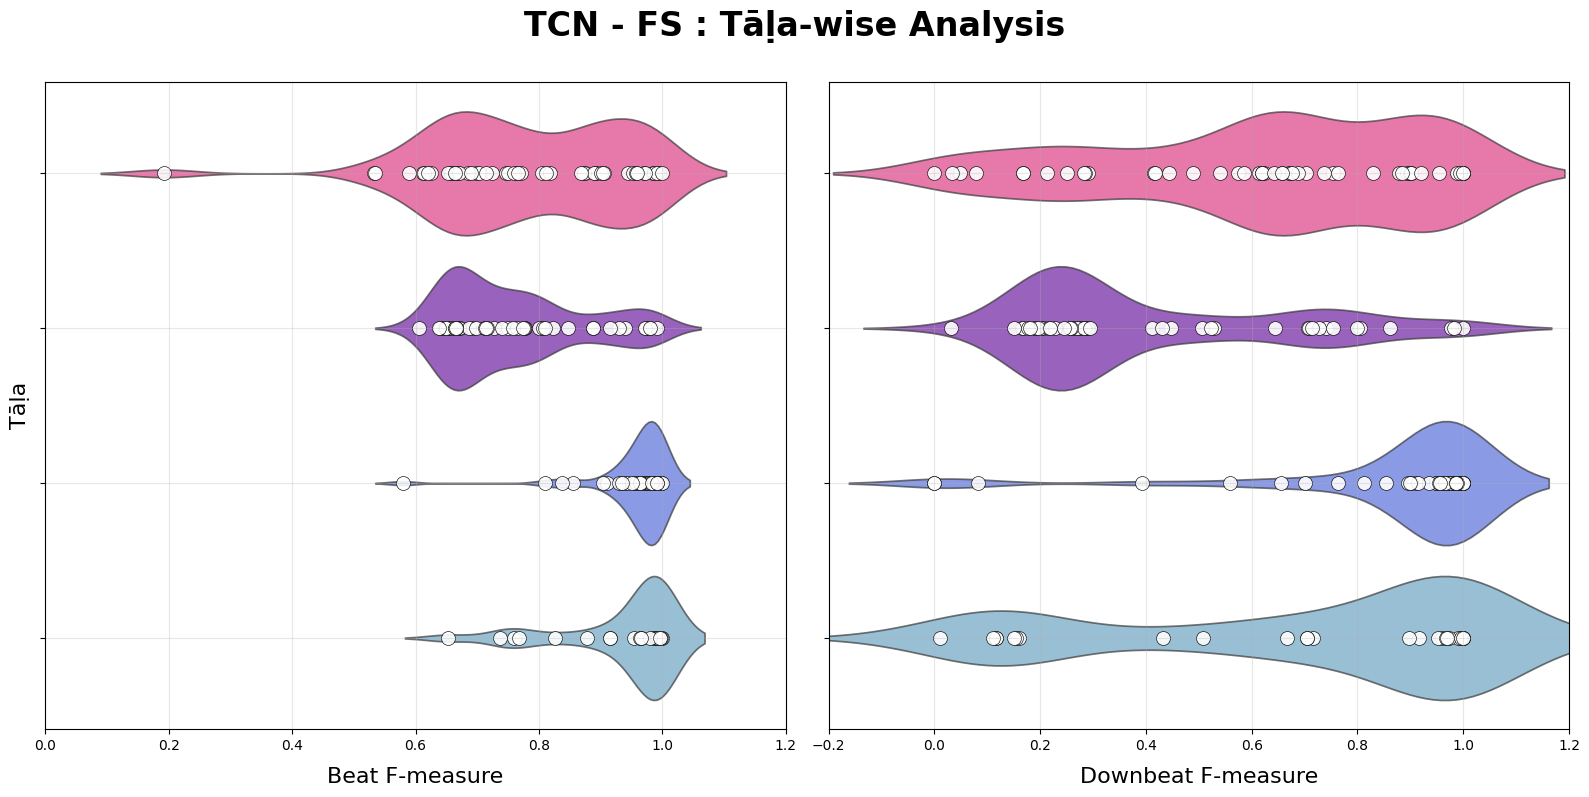

In [ ]:
if final_df is not None:
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Consistent ordering and colors
    taala_order = ['adi', 'rupakam', 'mishraChapu', 'khandaChapu']
    violin_colors = ["#F72585", "#7209B7", "#4361EE", "#5FA8D3"]
    #violin_colors = ["#D1492E", "#F4D35E", "#2FBF71", "#0B6E4F"]
    taala_to_color = {t: violin_colors[i % len(violin_colors)] for i, t in enumerate(taala_order)}

    # Define plots: (column, x-axis label, axis)
    plots = [
        ('beat_F', 'Beat F-measure', ax1),
        ('downbeat_F', 'Downbeat F-measure', ax2),
    ]

    for x_col, x_label, ax in plots:
        sns.violinplot(
            data=final_df,
            y='taala',
            x=x_col,
            order=taala_order,
            ax=ax,
            inner=None,
            alpha=0.7,
            palette=violin_colors[:4],
            hue='taala',
            bw_adjust=0.7
        )

        # Overlay scatter points per tāla
        for i, taala in enumerate(taala_order):
            taala_data = final_df[final_df['taala'] == taala]
            ax.scatter(
                taala_data[x_col],
                [i] * len(taala_data),
                alpha=0.9,
                color='white',
                edgecolors='black',
                linewidth=0.5,
                s=100
            )

        ax.set_xlabel(x_label, fontsize=16, labelpad=10)
        if ax is ax1:
            ax.set_ylabel('Tāḷa', fontsize=16)
            ax.set_yticklabels([])
            ax.set_xlim(0, 1.2)

        else:
            ax.set_ylabel('')
            ax.set_yticklabels([])
            ax.set_xlim(-0.2, 1.2)

        ax.grid(True, alpha=0.3)
        #ax.set_xlim(-0.25, 1.25)

    # Common y-limits
    y_limits = ax1.get_ylim()
    ax1.set_ylim(y_limits)
    ax2.set_ylim(y_limits)

    # Title
    fig.suptitle('TCN - FS : Tāḷa-wise Analysis', fontsize=24, fontweight='bold', y=0.99)

    '''
    # Legend directly under the suptitle
    legend_handles = [Patch(facecolor=taala_to_color.get(t, '#999999'), edgecolor='none', label=t) for t in taala_order]
    fig.legend(
        handles=legend_handles,
        title='Tāḷa',
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.01),  # slightly below the suptitle
        ncol=len(taala_order),
        borderaxespad=0.0,
        fontsize=14,
        title_fontsize=14
    )
    '''
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No data available for plotting")

In [15]:
# Find worst performing track for each taala by beat F-measure
worst_beat_by_taala = final_df.loc[final_df.groupby('taala')['beat_F'].idxmin()]

# Find worst performing track for each taala by downbeat F-measure  
worst_downbeat_by_taala = final_df.loc[final_df.groupby('taala')['downbeat_F'].idxmin()]

# Display results
print("=== WORST PERFORMING TRACKS BY BEAT F-MEASURE ===")
print(worst_beat_by_taala[['track_id', 'taala', 'beat_F', 'beat_CMLt', 'beat_AMLt']])

print("\n=== WORST PERFORMING TRACKS BY DOWNBEAT F-MEASURE ===")
print(worst_downbeat_by_taala[['track_id', 'taala', 'downbeat_F', 'downbeat_CMLt', 'downbeat_AMLt']])

=== WORST PERFORMING TRACKS BY BEAT F-MEASURE ===
    track_id        taala    beat_F  beat_CMLt  beat_AMLt
46     10047          adi  0.192975   0.100241   0.458864
73     11024      rupakam  0.605962   0.000145   0.903054
104    12005  mishraChapu  0.579373   0.000000   0.472265
165    13018  khandaChapu  0.652135   0.000000   0.631267

=== WORST PERFORMING TRACKS BY DOWNBEAT F-MEASURE ===
    track_id        taala  downbeat_F  downbeat_CMLt  downbeat_AMLt
47     10048          adi    0.000000            0.0       1.000000
89     11040      rupakam    0.032501            0.0       0.000000
112    12013  mishraChapu    0.000000            0.0       0.995122
165    13018  khandaChapu    0.011494            0.0       0.045198


/var/folders/fv/sqy09dps0vz7wg8jbkcgwk3h0000gn/T/ipykernel_1865/1248970405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_beat_by_taala = final_df.loc[final_df.groupby('taala')['beat_F'].idxmin()]
/var/folders/fv/sqy09dps0vz7wg8jbkcgwk3h0000gn/T/ipykernel_1865/1248970405.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  worst_downbeat_by_taala = final_df.loc[final_df.groupby('taala')['downbeat_F'].idxmin()]
